Acknowledgement: This code was initially inspired by the lab "COMP34212_Lab2b_Keras_CNN_CIFAR_2025" before undergoing significant changes.

# Setup

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, Add
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import backend as K


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

print('Libraries imported.')

Libraries imported.


# Data Preperation

In [ ]:



cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

cifar100_coarse_labels = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]


fine_to_coarse_mapping = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7,
    8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11,
    16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10,
    24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0, 31: 11,
    32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5,
    40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17,
    48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0,
    56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
    64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10,
    72: 0, 73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13,
    80: 16, 81: 18, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5,
    88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0,
    96: 17, 97: 8, 98: 14, 99: 13
}

In [ ]:

BATCH_SIZE = 256
N_EPOCH = 50
N_CLASSES = 100
N_SUPERCLASSES = 20
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')


IMG_CHANNELS = 3
IMG_ROWS = 32
IMG_COLS = 32

print('Image variables initialisation')


Main variables initialised.
Image variables initialisation


In [ ]:

(input_X_train, output_y_train), (input_X_test, output_y_test) = cifar100.load_data(label_mode='fine')
print('input_X_train shape:', input_X_train.shape)
print(input_X_train.shape[0], 'train samples')
print(input_X_test.shape[0], 'test samples')


output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES)


input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
input_X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Sample input image class: apple


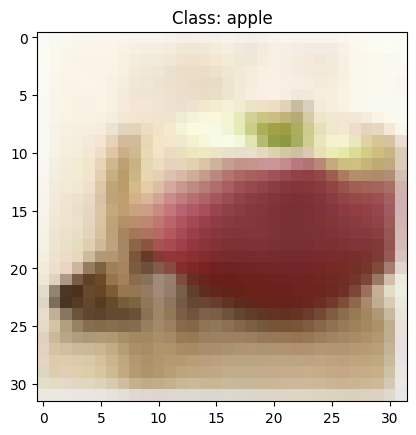

Sample input image class: boy


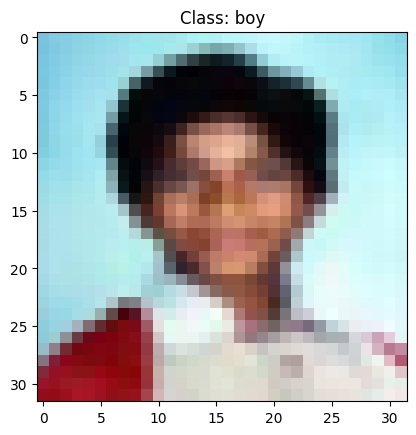

In [ ]:

Selected_Image = 2
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

Selected_Image = 3
image = input_X_train[Selected_Image]
print("Sample input image class:", cifar100_fine_labels[output_y_train[Selected_Image][0]])
plt.imshow(image)
plt.title(f"Class: {cifar100_fine_labels[output_y_train[Selected_Image][0]]}")
plt.show()

# Training

In [ ]:
def identity_block(x, filters, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:
def conv_block(x, filters, stride, dropout_rate):
    x_skip = x


    x = Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)


    x_skip = Conv2D(filters, 1, strides=stride, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x


In [ ]:

inputs = Input(shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS))


x = Conv2D(64, 3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)




x = conv_block(x, 64, stride=1, dropout_rate=0.3)
x = identity_block(x, 64, dropout_rate=0.3)


x = conv_block(x, 128, stride=2, dropout_rate=0.3)
x = identity_block(x, 128, dropout_rate=0.3)


x = conv_block(x, 256, stride=2, dropout_rate=0.3)
x = identity_block(x, 256, dropout_rate=0.3)


x = Dropout(0.2)(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch+1}")
        print(f"LR: {lr:.1e}\n")
        print(f"  Training Loss: {logs['loss']:.4f} - Training Accuracy: {logs['accuracy']:.4f}")
        print(f"  Validation Loss: {logs['val_loss']:.4f} - Validation Accuracy: {logs['val_accuracy']:.4f}")
        if logs['accuracy'] - logs['val_accuracy'] > 0.15:
            print(f"! Overfitting: {logs['accuracy']-logs['val_accuracy']:.4f} gap")



In [ ]:

OPTIM1 = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM1, metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ dropout[0][0],         │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 2,811,940 (10.73 MB)

 Trainable params: 2,807,332 (10.71 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [ ]:

early_stop = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=8,
    restore_best_weights=True,
    start_from_epoch=10
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=6,
    min_lr=1e-5,
    mode='max',
    cooldown=2,
    verbose=1
)

In [ ]:

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    input_X_train, output_Y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCH,
    validation_split=VALIDATION_SPLIT,
    verbose=VERBOSE,
    callbacks=[
        early_stop,
        checkpoint,
        TrainingMonitor(),
        reduce_lr,
    ]
)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0716 - loss: 4.2265
Epoch 1: val_accuracy improved from -inf to 0.01350, saving model to best_model.h5



Epoch 1
LR: 1.0e-03

  Training Loss: 3.8806 - Training Accuracy: 0.1076
  Validation Loss: 7.8677 - Validation Accuracy: 0.0135
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 131ms/step - accuracy: 0.0718 - loss: 4.2243 - val_accuracy: 0.0135 - val_loss: 7.8677 - learning_rate: 0.0010
Epoch 2/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1969 - loss: 3.2841
Epoch 2: val_accuracy improved from 0.01350 to 0.03770, saving model to best_model.h5



Epoch 2
LR: 1.0e-03

  Training Loss: 3.1384 - Training Accuracy: 0.2233
  Validation Loss: 6.4406 - Validation Accuracy: 0.0377
! Overfitting: 0.1856 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.1974 - loss: 3.2814 - val_accuracy: 0.0377 - val_loss: 6.4406 - learning_rate: 0.0010
Epoch 3/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2927 - loss: 2.7669
Epoch 3: val_accuracy improved from 0.03770 to 0.10530, saving model to best_model.h5



Epoch 3
LR: 1.0e-03

  Training Loss: 2.6642 - Training Accuracy: 0.3133
  Validation Loss: 4.8506 - Validation Accuracy: 0.1053
! Overfitting: 0.2080 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2931 - loss: 2.7649 - val_accuracy: 0.1053 - val_loss: 4.8506 - learning_rate: 0.0010
Epoch 4/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3731 - loss: 2.3701
Epoch 4: val_accuracy improved from 0.10530 to 0.11920, saving model to best_model.h5



Epoch 4
LR: 1.0e-03

  Training Loss: 2.3173 - Training Accuracy: 0.3855
  Validation Loss: 4.8880 - Validation Accuracy: 0.1192
! Overfitting: 0.2663 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3733 - loss: 2.3691 - val_accuracy: 0.1192 - val_loss: 4.8880 - learning_rate: 0.0010
Epoch 5/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4337 - loss: 2.0984
Epoch 5: val_accuracy improved from 0.11920 to 0.17850, saving model to best_model.h5



Epoch 5
LR: 1.0e-03

  Training Loss: 2.0523 - Training Accuracy: 0.4454
  Validation Loss: 4.3924 - Validation Accuracy: 0.1785
! Overfitting: 0.2669 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4339 - loss: 2.0975 - val_accuracy: 0.1785 - val_loss: 4.3924 - learning_rate: 0.0010
Epoch 6/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4838 - loss: 1.8816
Epoch 6: val_accuracy improved from 0.17850 to 0.22210, saving model to best_model.h5



Epoch 6
LR: 1.0e-03

  Training Loss: 1.8457 - Training Accuracy: 0.4922
  Validation Loss: 3.5863 - Validation Accuracy: 0.2221
! Overfitting: 0.2701 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4839 - loss: 1.8811 - val_accuracy: 0.2221 - val_loss: 3.5863 - learning_rate: 0.0010
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5271 - loss: 1.6937
Epoch 7: val_accuracy improved from 0.22210 to 0.27940, saving model to best_model.h5



Epoch 7
LR: 1.0e-03

  Training Loss: 1.6805 - Training Accuracy: 0.5303
  Validation Loss: 3.4949 - Validation Accuracy: 0.2794
! Overfitting: 0.2509 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5271 - loss: 1.6936 - val_accuracy: 0.2794 - val_loss: 3.4949 - learning_rate: 0.0010
Epoch 8/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5668 - loss: 1.5258
Epoch 8: val_accuracy improved from 0.27940 to 0.33070, saving model to best_model.h5



Epoch 8
LR: 1.0e-03

  Training Loss: 1.5369 - Training Accuracy: 0.5653
  Validation Loss: 2.9603 - Validation Accuracy: 0.3307
! Overfitting: 0.2346 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5668 - loss: 1.5260 - val_accuracy: 0.3307 - val_loss: 2.9603 - learning_rate: 0.0010
Epoch 9/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5950 - loss: 1.4090
Epoch 9: val_accuracy did not improve from 0.33070

Epoch 9
LR: 1.0e-03

  Training Loss: 1.4079 - Training Accuracy: 0.5974
  Validation Loss: 3.1850 - Validation Accuracy: 0.2942
! Overfitting: 0.3031 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5950 - loss: 1.4090 - val_accuracy: 0.2942 - val_loss: 3.1850 - learning_rate: 0.0010
Epoch 10/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6245 - loss: 1.3006
Epoch 10: val_accuracy improved from 0.33070 to 0.42390, saving model to best_model.h5



Epoch 10
LR: 1.0e-03

  Training Loss: 1.2968 - Training Accuracy: 0.6241
  Validation Loss: 2.2774 - Validation Accuracy: 0.4239
! Overfitting: 0.2002 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6245 - loss: 1.3005 - val_accuracy: 0.4239 - val_loss: 2.2774 - learning_rate: 0.0010
Epoch 11/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6541 - loss: 1.1781
Epoch 11: val_accuracy did not improve from 0.42390

Epoch 11
LR: 1.0e-03

  Training Loss: 1.1872 - Training Accuracy: 0.6531
  Validation Loss: 2.5991 - Validation Accuracy: 0.4195
! Overfitting: 0.2336 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6541 - loss: 1.1783 - val_accuracy: 0.4195 - val_loss: 2.5991 - learning_rate: 0.0010
Epoch 12/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6790 - loss: 1.0833
Epoch 12: val_accuracy did not improve from 0.42390

Epoch 12
LR: 1.0e-03

  Training Loss: 1.0966 - Training Accuracy: 0.6767
  Validation Loss: 2.5349 - Validation Accuracy


Epoch 17
LR: 5.0e-04

  Training Loss: 0.5352 - Training Accuracy: 0.8436
  Validation Loss: 1.7068 - Validation Accuracy: 0.5625
! Overfitting: 0.2811 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8355 - loss: 0.5623 - val_accuracy: 0.5625 - val_loss: 1.7068 - learning_rate: 5.0000e-04
Epoch 18/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8740 - loss: 0.4443
Epoch 18: val_accuracy improved from 0.56250 to 0.56620, saving model to best_model.h5



Epoch 18
LR: 5.0e-04

  Training Loss: 0.4546 - Training Accuracy: 0.8700
  Validation Loss: 1.7419 - Validation Accuracy: 0.5662
! Overfitting: 0.3038 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8740 - loss: 0.4445 - val_accuracy: 0.5662 - val_loss: 1.7419 - learning_rate: 5.0000e-04
Epoch 19/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8864 - loss: 0.3935
Epoch 19: val_accuracy improved from 0.56620 to 0.58710, saving model to best_model.h5



Epoch 19
LR: 5.0e-04

  Training Loss: 0.4062 - Training Accuracy: 0.8828
  Validation Loss: 1.6686 - Validation Accuracy: 0.5871
! Overfitting: 0.2957 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8864 - loss: 0.3938 - val_accuracy: 0.5871 - val_loss: 1.6686 - learning_rate: 5.0000e-04
Epoch 20/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9004 - loss: 0.3538
Epoch 20: val_accuracy did not improve from 0.58710

Epoch 20
LR: 5.0e-04

  Training Loss: 0.3644 - Training Accuracy: 0.8964
  Validation Loss: 1.8230 - Validation Accuracy: 0.5695
! Overfitting: 0.3269 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9004 - loss: 0.3540 - val_accuracy: 0.5695 - val_loss: 1.8230 - learning_rate: 5.0000e-04
Epoch 21/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9103 - loss: 0.3193
Epoch 21: val_accuracy did not improve from 0.58710

Epoch 21
LR: 5.0e-04

  Training Loss: 0.3283 - Training Accuracy: 0.9065
  Validation Loss: 1.9825 - Validation 


Epoch 26
LR: 2.5e-04

  Training Loss: 0.1381 - Training Accuracy: 0.9691
  Validation Loss: 1.7032 - Validation Accuracy: 0.6132
! Overfitting: 0.3559 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9665 - loss: 0.1461 - val_accuracy: 0.6132 - val_loss: 1.7032 - learning_rate: 2.5000e-04
Epoch 27/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9758 - loss: 0.1173
Epoch 27: val_accuracy did not improve from 0.61320

Epoch 27
LR: 2.5e-04

  Training Loss: 0.1181 - Training Accuracy: 0.9754
  Validation Loss: 1.7981 - Validation Accuracy: 0.6111
! Overfitting: 0.3643 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9758 - loss: 0.1173 - val_accuracy: 0.6111 - val_loss: 1.7981 - learning_rate: 2.5000e-04
Epoch 28/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9803 - loss: 0.1046
Epoch 28: val_accuracy did not improve from 0.61320

Epoch 28
LR: 2.5e-04

  Training Loss: 0.1054 - Training Accuracy: 0.9803
  Validation Loss: 1.7520 - Validation 


Epoch 30
LR: 2.5e-04

  Training Loss: 0.0869 - Training Accuracy: 0.9836
  Validation Loss: 1.7996 - Validation Accuracy: 0.6146
! Overfitting: 0.3690 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9839 - loss: 0.0847 - val_accuracy: 0.6146 - val_loss: 1.7996 - learning_rate: 2.5000e-04
Epoch 31/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9846 - loss: 0.0805
Epoch 31: val_accuracy improved from 0.61460 to 0.61790, saving model to best_model.h5



Epoch 31
LR: 2.5e-04

  Training Loss: 0.0828 - Training Accuracy: 0.9840
  Validation Loss: 1.8122 - Validation Accuracy: 0.6179
! Overfitting: 0.3661 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9846 - loss: 0.0805 - val_accuracy: 0.6179 - val_loss: 1.8122 - learning_rate: 2.5000e-04
Epoch 32/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9880 - loss: 0.0725
Epoch 32: val_accuracy did not improve from 0.61790

Epoch 32
LR: 2.5e-04

  Training Loss: 0.0744 - Training Accuracy: 0.9871
  Validation Loss: 1.9196 - Validation Accuracy: 0.6047
! Overfitting: 0.3824 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9880 - loss: 0.0726 - val_accuracy: 0.6047 - val_loss: 1.9196 - learning_rate: 2.5000e-04
Epoch 33/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9897 - loss: 0.0659
Epoch 33: val_accuracy did not improve from 0.61790

Epoch 33
LR: 2.5e-04

  Training Loss: 0.0671 - Training Accuracy: 0.9886
  Validation Loss: 1.9057 - Validation 


Epoch 35
LR: 2.5e-04

  Training Loss: 0.0616 - Training Accuracy: 0.9888
  Validation Loss: 1.9050 - Validation Accuracy: 0.6218
! Overfitting: 0.3670 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9890 - loss: 0.0611 - val_accuracy: 0.6218 - val_loss: 1.9050 - learning_rate: 2.5000e-04
Epoch 36/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9900 - loss: 0.0568
Epoch 36: val_accuracy did not improve from 0.62180

Epoch 36
LR: 2.5e-04

  Training Loss: 0.0587 - Training Accuracy: 0.9894
  Validation Loss: 1.9954 - Validation Accuracy: 0.6053
! Overfitting: 0.3841 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9900 - loss: 0.0568 - val_accuracy: 0.6053 - val_loss: 1.9954 - learning_rate: 2.5000e-04
Epoch 37/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9916 - loss: 0.0519
Epoch 37: val_accuracy did not improve from 0.62180

Epoch 37
LR: 2.5e-04

  Training Loss: 0.0533 - Training Accuracy: 0.9911
  Validation Loss: 1.8988 - Validation 


Epoch 42
LR: 1.3e-04

  Training Loss: 0.0315 - Training Accuracy: 0.9962
  Validation Loss: 1.9040 - Validation Accuracy: 0.6279
! Overfitting: 0.3683 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9960 - loss: 0.0333 - val_accuracy: 0.6279 - val_loss: 1.9040 - learning_rate: 1.2500e-04
Epoch 43/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9967 - loss: 0.0273
Epoch 43: val_accuracy improved from 0.62790 to 0.63190, saving model to best_model.h5



Epoch 43
LR: 1.3e-04

  Training Loss: 0.0274 - Training Accuracy: 0.9968
  Validation Loss: 1.9228 - Validation Accuracy: 0.6319
! Overfitting: 0.3649 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9967 - loss: 0.0273 - val_accuracy: 0.6319 - val_loss: 1.9228 - learning_rate: 1.2500e-04
Epoch 44/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9968 - loss: 0.0262
Epoch 44: val_accuracy improved from 0.63190 to 0.63870, saving model to best_model.h5



Epoch 44
LR: 1.3e-04

  Training Loss: 0.0263 - Training Accuracy: 0.9968
  Validation Loss: 1.9006 - Validation Accuracy: 0.6387
! Overfitting: 0.3581 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9968 - loss: 0.0262 - val_accuracy: 0.6387 - val_loss: 1.9006 - learning_rate: 1.2500e-04
Epoch 45/50
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9972 - loss: 0.0255
Epoch 45: val_accuracy did not improve from 0.63870

Epoch 45
LR: 1.3e-04

  Training Loss: 0.0254 - Training Accuracy: 0.9974
  Validation Loss: 1.9310 - Validation Accuracy: 0.6283
! Overfitting: 0.3691 gap
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9972 - loss: 0.0255 - val_accuracy: 0.6283 - val_loss: 1.9310 - learning_rate: 1.2500e-04
Epoch 46/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9976 - loss: 0.0239
Epoch 46: val_accuracy did not improve from 0.63870

Epoch 46
LR: 1.3e-04

  Training Loss: 0.0247 - Training Accuracy: 0.9971
  Validation Loss: 1.9283 - Validation 

In [ ]:

predictions = model.predict(input_X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(output_Y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


## Evaluation

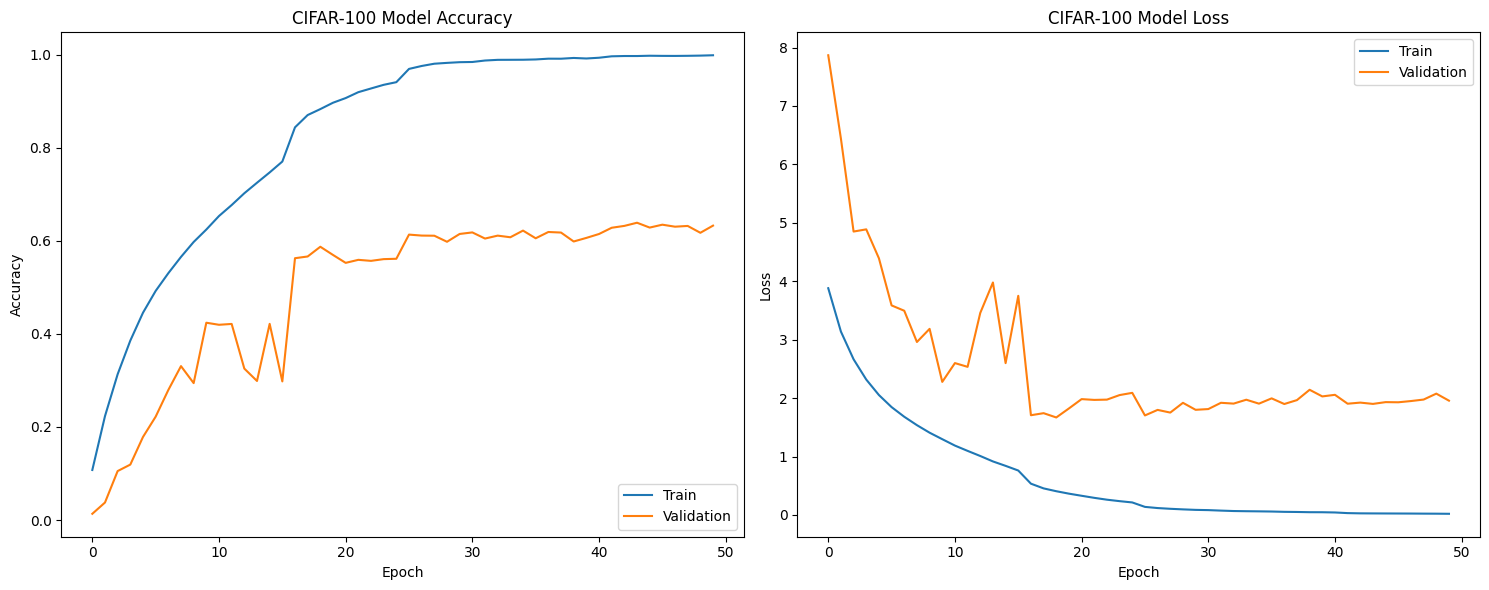

In [ ]:


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CIFAR-100 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CIFAR-100 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:


test_loss, test_accuracy = model.evaluate(input_X_test, output_Y_test, verbose=VERBOSE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


superclass_y_true = np.array([fine_to_coarse_mapping[y] for y in y_true])
superclass_y_pred = np.array([fine_to_coarse_mapping[y] for y in y_pred])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6408 - loss: 1.9003

Test Loss: 1.8803
Test Accuracy: 0.6358
